In [1]:
rand_state = 12

# Cleaning Pipeline

In [2]:
from BeerMe.Pipeline import *

In [3]:
df = IMPORT_CLEAN_STEP(db_path='data/beer.db')



1. NA Count...
ABV                923
global_rating        0
user_rating       3882
IBU              47035
dtype: int64


2. Finding IQR outliers...
FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


NA Count...
ABV              0
global_rating    0
user_rating      0
IBU              0
dtype: int64


In [4]:
df = df[['username', 'beer_name', 'beer_description', 'brewery', 'ABV', 'IBU', 'global_rating', 'user_rating']]

In [5]:
df.head()

,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,44.1594,4.38,4.25
1,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,44.1594,4.14,5.00
2,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,44.1594,4.10,4.50
3,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25
4,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00


# 0. Baseline - Average 

In [6]:
global_mean = np.mean(df['user_rating'])
print("Global user_rating mean = {:.2f}".format(global_mean))

Global user_rating mean = 3.71


In [7]:
beer_list = list(df[df['username']=='tsharp93']['beer_name'])

In [8]:
estimated_rating_list = []
error_list = []
for beer in beer_list:
    try:
        estimated_rating = global_mean
        estimated_rating_list.append(estimated_rating)

        user_rating = df[(df['username']=='tsharp93') & (df['beer_name']==beer)]['user_rating'].iloc[0].astype(float)
        error_list.append(estimated_rating-user_rating)
    except IndexError:
        print(beer)

In [9]:
mse = np.mean(np.array(error_list)**2)
mae = np.absolute(error_list).mean()
quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

print("MSE = {:.2f}".format(mse))
print("MAE = {:.2f}".format(mae))
print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

MSE = 0.23
MAE = 0.40
Errors within 0.25 = 35.00 %
Errors within 0.50 = 67.50 %


# 1. (Semi) Cold Start - Collaborative Filtering

In [10]:
user_of_interest = 'tsharp93'

### For use when a user does not have enough data to build a model for his/her preferences

In [11]:
df = COSINE_STEP(df, user_of_interest)

User of Reference for Cosine Sim = tsharp93


In [12]:
beer_list = list(df[df['username']=='tsharp93']['beer_name'])

In [13]:
estimated_rating_list = []
error_list = []
for beer in beer_list:
    try:
        estimated_rating = df[ (df.sort_values('nearest_neighbor_rank')['beer_name'] == beer) & (df['username']!=user_of_interest) ]['user_rating'].iloc[0]
        estimated_rating_list.append(estimated_rating)

        user_rating = df[(df['username']=='tsharp93') & (df['beer_name']==beer)]['user_rating'].iloc[0].astype(float)
        error_list.append(estimated_rating-user_rating)
    except IndexError:
        print(beer)

Sig Sour 6.5
The Drongo
They Both Melt
Black Matter
The Caucasian
Caturro Coffee Cream Ale
Shiner Day Quencher
Barrel-Aged 4Beans
Marionberry Lavender Sour Ale
Southern Torrent Saison
The Drongo
They Both Melt


In [14]:
mse = np.mean(np.array(error_list)**2)
mae = np.absolute(error_list).mean()
quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

print("MSE = {:.2f}".format(mse))
print("MAE = {:.2f}".format(mae))
print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

MSE = 0.27
MAE = 0.38
Errors within 0.25 = 35.71 %
Errors within 0.50 = 53.57 %


#### Problems with this approach: 
#### (1) Need another user to have the beer I have selected. If I want to get my user_rating for a beer that no one has tried, I can't do that. 
#### (2) Not very accurate. Almost half the points are outside of 0.5 error - sometimes worse than baseline

# 2. Content Based Filtering 

### *Assumes the user of interest has enough data to build a model 

In [15]:
user_of_interest = 'tnt'

### A. Encoding Beer Description

In [16]:
user_df = df[df['username'] == user_of_interest]
len(user_df)

1684

In [17]:
user_df.head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
36726,36.0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,44.1594,4.38,4.25
36727,36.0,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,44.1594,4.14,5.00
36728,36.0,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,44.1594,4.10,4.50
36729,36.0,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25
36730,36.0,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00


#### Feature Engineering - Encode Categorical Beer Description

In [18]:
user_df = convert_categorical(user_df, ['beer_description'])

In [19]:
user_df.drop(['username', 'nearest_neighbor_rank', 'beer_description', 'beer_name', 'brewery'], axis=1, inplace=True)

In [20]:
user_df.shape

(1684, 136)

In [21]:
user_df.head()

,ABV,IBU,global_rating,user_rating,beer_description_Altbier,beer_description_American Wild Ale,beer_description_Barleywine - American,beer_description_Barleywine - English,beer_description_Belgian Blonde,beer_description_Belgian Dubbel,...,beer_description_Stout - Russian Imperial,beer_description_Strong Ale - American,beer_description_Strong Ale - English,beer_description_Table Beer,beer_description_Traditional Ale,beer_description_Wheat Beer - American Pale Wheat,beer_description_Wheat Beer - Other,beer_description_Wheat Wine,beer_description_Winter Ale,beer_description_Witbier
36726,8.0,44.1594,4.38,4.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36727,5.2,44.1594,4.14,5.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36728,3.7,44.1594,4.10,4.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36729,4.1,39,3.81,4.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36730,8.2,52,3.82,4.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Build Model and Score

In [22]:
features = user_df.columns[list(user_df.columns != 'user_rating')]
target = 'user_rating'

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(user_df[features], user_df[target], random_state=rand_state)

from sklearn.linear_model import LassoCV
lassocv = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
lassocv.fit(X_train, y_train)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=lassocv.alpha_,fit_intercept=True, normalize=True, random_state=rand_state)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0004187680843829271, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=12, selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
coef_dropped_perc = 100*np.sum(lasso.coef_ == 0) / len(lasso.coef_)
print("Percentage of estimators dropped = {:.2f} %".format(coef_dropped_perc))

features_dropped = list(features[lasso.coef_ == 0])
print("Features dropped: ", features_dropped)

features_kept = list(features[lasso.coef_ != 0])
print("Features kept: ", features_kept)

Percentage of estimators dropped = 63.70 %
Features dropped:  ['beer_description_Altbier', 'beer_description_Barleywine - American', 'beer_description_Barleywine - English', 'beer_description_Belgian Blonde', 'beer_description_Belgian Strong Golden Ale', 'beer_description_Belgian Tripel', 'beer_description_Bière de Champagne / Bière Brut', 'beer_description_Bière de Garde', 'beer_description_Bière de Mars', 'beer_description_Blonde Ale', 'beer_description_Bock - Doppelbock', 'beer_description_Bock - Hell / Maibock / Lentebock', 'beer_description_Brown Ale - Belgian', 'beer_description_Brown Ale - English', 'beer_description_Brown Ale - Imperial / Double', 'beer_description_California Common', 'beer_description_Cider - Traditional', 'beer_description_Dunkelweizen', 'beer_description_English Bitter', 'beer_description_Fruit Beer', 'beer_description_Golden Ale', 'beer_description_Grisette', 'beer_description_Gruit / Ancient Herbed Ale', 'beer_description_IPA - American', 'beer_description

In [25]:
preds = lasso.predict(X_test)
error_list = preds - y_test

mse = np.mean(np.array(error_list)**2)
mae = np.absolute(error_list).mean()
quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

print("MSE = {:.2f}".format(mse))
print("MAE = {:.2f}".format(mae))
print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

MSE = 0.23
MAE = 0.36
Errors within 0.25 = 46.79 %
Errors within 0.50 = 74.58 %


##### Improved Accuracy over both Cold Start and Baseline

### B. NLP (Count Vectorizer)

In [26]:
user_df = df[df['username'] == user_of_interest]

In [27]:
user_df.head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
36726,36.0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,44.1594,4.38,4.25
36727,36.0,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,44.1594,4.14,5.00
36728,36.0,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,44.1594,4.10,4.50
36729,36.0,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25
36730,36.0,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00


#### Feature Engineering - Count Vectorizer

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [29]:
X = vect.fit_transform(user_df['beer_description'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
user_df = pd.concat([user_df.reset_index(drop=True), tfidf_df], axis=1)

In [30]:
user_df.drop(['username', 'nearest_neighbor_rank', 'beer_description', 'beer_name', 'brewery'], axis=1, inplace=True)

In [31]:
user_df.shape

(1684, 130)

In [32]:
user_df.head()

,ABV,IBU,global_rating,user_rating,abbey,ale,altbier,amber,american,ancient,...,wee,weisse,wheat,white,wild,wine,winter,witbier,yam,zwickelbier
0,8.0,44.1594,4.38,4.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.2,44.1594,4.14,5.00,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3.7,44.1594,4.10,4.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.1,39,3.81,4.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.2,52,3.82,4.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Build Model and Score

In [33]:
features = user_df.columns[list(user_df.columns != 'user_rating')]
target = 'user_rating'

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(user_df[features], user_df[target], random_state=rand_state)

from sklearn.linear_model import LassoCV
lassocv = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
lassocv.fit(X_train, y_train)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=lassocv.alpha_,fit_intercept=True, normalize=True, random_state=rand_state)
lasso.fit(X_train, y_train)

Lasso(alpha=0.00027552143614173187, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=12, selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
coef_dropped_perc = 100*np.sum(lasso.coef_ == 0) / len(lasso.coef_)
print("Percentage of estimators dropped = {:.2f} %".format(coef_dropped_perc))

features_dropped = list(features[lasso.coef_ == 0])
print("Features dropped: ", features_dropped)

features_kept = list(features[lasso.coef_ != 0])
print("Features kept: ", features_kept)

Percentage of estimators dropped = 53.49 %
Features dropped:  ['altbier', 'amber', 'american', 'ancient', 'belgian', 'berliner', 'bière', 'blonde', 'bock', 'braggot', 'bruin', 'brut', 'california', 'cascadian', 'champagne', 'cider', 'common', 'de', 'doppelbock', 'dortmunder', 'double', 'dunkelweizen', 'euro', 'export', 'flanders', 'framboise', 'fruit', 'garde', 'german', 'golden', 'gose', 'grape', 'gruit', 'heavy', 'hell', 'herbed', 'international', 'ipa', 'italian', 'kellerbier', 'kriek', 'kölsch', 'lambic', 'lentebock', 'maibock', 'mars', 'milk', 'oatmeal', 'old', 'oud', 'patersbier', 'pilsner', 'porter', 'pumpkin', 'pyment', 'roggenbier', 'schwarzbier', 'scotch', 'session', 'special', 'strong', 'triple', 'vienna', 'wee', 'weisse', 'wheat', 'winter', 'yam', 'zwickelbier']
Features kept:  ['ABV', 'IBU', 'global_rating', 'abbey', 'ale', 'baltic', 'barleywine', 'beer', 'bitter', 'black', 'brown', 'coffee', 'cream', 'czech', 'dark', 'dry', 'dubbel', 'england', 'english', 'extra', 'farmho

In [36]:
preds = lasso.predict(X_test)
error_list = preds - y_test

mse = np.mean(np.array(error_list)**2)
mae = np.absolute(error_list).mean()
quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

print("MSE = {:.2f}".format(mse))
print("MAE = {:.2f}".format(mae))
print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

MSE = 0.23
MAE = 0.36
Errors within 0.25 = 48.46 %
Errors within 0.50 = 72.92 %


### C. NLP (TFIDF)

In [37]:
user_df = df[df['username'] == user_of_interest]

In [38]:
user_df.head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
36726,36.0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,44.1594,4.38,4.25
36727,36.0,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,44.1594,4.14,5.00
36728,36.0,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,44.1594,4.10,4.50
36729,36.0,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25
36730,36.0,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00


#### Feature Engineering - Count Vectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()

In [40]:
X = vect.fit_transform(user_df['beer_description'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
user_df = pd.concat([user_df.reset_index(drop=True), tfidf_df], axis=1)

In [41]:
user_df.drop(['username', 'nearest_neighbor_rank', 'beer_description', 'beer_name', 'brewery'], axis=1, inplace=True)

In [42]:
user_df.shape

(1684, 130)

In [43]:
user_df.head()

,ABV,IBU,global_rating,user_rating,abbey,ale,altbier,amber,american,ancient,...,wee,weisse,wheat,white,wild,wine,winter,witbier,yam,zwickelbier
0,8.0,44.1594,4.38,4.25,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.2,44.1594,4.14,5.00,0.0,0.490558,0.0,0.0,0.472183,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.7,44.1594,4.10,4.50,0.0,0.346861,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.1,39,3.81,4.25,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.2,52,3.82,4.00,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Build Model and Score

In [44]:
features = user_df.columns[list(user_df.columns != 'user_rating')]
target = 'user_rating'

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(user_df[features], user_df[target], random_state=rand_state)

from sklearn.linear_model import LassoCV
lassocv = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
lassocv.fit(X_train, y_train)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=lassocv.alpha_,fit_intercept=True, normalize=True, random_state=rand_state)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0002954326049359895, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=12, selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
coef_dropped_perc = 100*np.sum(lasso.coef_ == 0) / len(lasso.coef_)
print("Percentage of estimators dropped = {:.2f} %".format(coef_dropped_perc))

features_dropped = list(features[lasso.coef_ == 0])
print("Features dropped: ", features_dropped)

features_kept = list(features[lasso.coef_ != 0])
print("Features kept: ", features_kept)

Percentage of estimators dropped = 55.81 %
Features dropped:  ['ale', 'altbier', 'amber', 'american', 'ancient', 'belgian', 'berliner', 'bière', 'blonde', 'bock', 'braggot', 'bruin', 'brut', 'california', 'cascadian', 'champagne', 'cider', 'common', 'czech', 'de', 'doppelbock', 'dortmunder', 'double', 'dunkelweizen', 'euro', 'export', 'flanders', 'framboise', 'garde', 'german', 'golden', 'gose', 'grape', 'gruit', 'heavy', 'hell', 'herbed', 'international', 'ipa', 'ipl', 'italian', 'kellerbier', 'kriek', 'kölsch', 'lambic', 'lentebock', 'maibock', 'mars', 'milk', 'milkshake', 'oatmeal', 'old', 'oud', 'patersbier', 'pilsner', 'porter', 'pumpkin', 'pyment', 'roggenbier', 'rye', 'schwarzbier', 'scotch', 'session', 'strong', 'triple', 'vienna', 'wee', 'weisse', 'wheat', 'winter', 'yam', 'zwickelbier']
Features kept:  ['ABV', 'IBU', 'global_rating', 'abbey', 'baltic', 'barleywine', 'beer', 'bitter', 'black', 'brown', 'coffee', 'cream', 'dark', 'dry', 'dubbel', 'england', 'english', 'extra', 

In [47]:
preds = lasso.predict(X_test)
error_list = preds - y_test

mse = np.mean(np.array(error_list)**2)
mae = np.absolute(error_list).mean()
quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

print("MSE = {:.2f}".format(mse))
print("MAE = {:.2f}".format(mae))
print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

MSE = 0.23
MAE = 0.36
Errors within 0.25 = 47.98 %
Errors within 0.50 = 73.63 %


In [48]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, preds)

0.3634093348762903

# Hybrid 

### More Data

In [49]:
user_of_interest = 'tnt'

In [50]:
try:
    df.drop('nearest_neighbor_rank', axis=1, inplace=True)
except:
    pass

In [51]:
df = COSINE_STEP(df, user_of_interest)

User of Reference for Cosine Sim = tnt


In [52]:
features = ['ABV', 'IBU', 'IBU', 'global_rating']
target = 'user_rating'

In [53]:
df.head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
0,1.0,xtrmstaticx,Cucumber Pepper Kolsch,Kölsch,Earthbound Brewing,6.7,44.1594,3.76,3.75
1,1.0,xtrmstaticx,Brummel,IPA - Sour,Narrow Gauge Brewing Company,7.0,30,4.17,4.50
2,1.0,xtrmstaticx,Urban Underdog Pale Ale,Pale Ale - American,Urban Chestnut Brewing Company,4.8,30,3.56,4.00
3,1.0,xtrmstaticx,Blushing Monk (2019),Fruit Beer,Founders Brewing Co.,9.2,20,4.01,4.50
4,1.0,xtrmstaticx,Big Shrug (2019),American Wild Ale,Fonta Flora Brewery,6.4,44.1594,4.10,4.25


In [54]:
%%time

min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]


mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]
        y_train = np.array(y_train).reshape(len(y_train), )

        X_test = df[df['username'] == user_of_interest][features]
        y_test = df[df['username'] == user_of_interest][target]
        y_test = np.array(y_test).reshape(len(y_test), )

        # train
        from sklearn.linear_model import LassoCV
        model = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
#         preds_unscaled = y_scaler.inverse_transform(preds)
#         y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds, y_test]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5))
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.3853 with % within 0.25 43.527315914489314 and % within 0.5 75.41567695961996 for n = 5 with alpha = 0.0
MAE = 0.37443 with % within 0.25 46.85273159144893 and % within 0.5 75.89073634204276 for n = 10 with alpha = 0.0
MAE = 0.38686 with % within 0.25 43.46793349168646 and % within 0.5 74.82185273159145 for n = 15 with alpha = 0.0
MAE = 0.38357 with % within 0.25 44.29928741092637 and % within 0.5 75.2375296912114 for n = 20 with alpha = 1e-05
MAE = 0.37953 with % within 0.25 45.605700712589076 and % within 0.5 74.94061757719714 for n = 25 with alpha = 0.0
MAE = 0.3765 with % within 0.25 46.43705463182898 and % within 0.5 74.70308788598575 for n = 30 with alpha = 1e-05
MAE = 0.37717 with % within 0.25 46.25890736342043 and % within 0.5 74.94061757719714 for n = 35 with alpha = 0.0
MAE = 0.38192 with % within 0.25 45.13064133016627 and % within 0.5 74.5249406175772 for n = 40 with alpha = 2e-05
MAE = 0.38325 with % within 0.25 44.71496437054632 and % within 0.5 74.287410926365

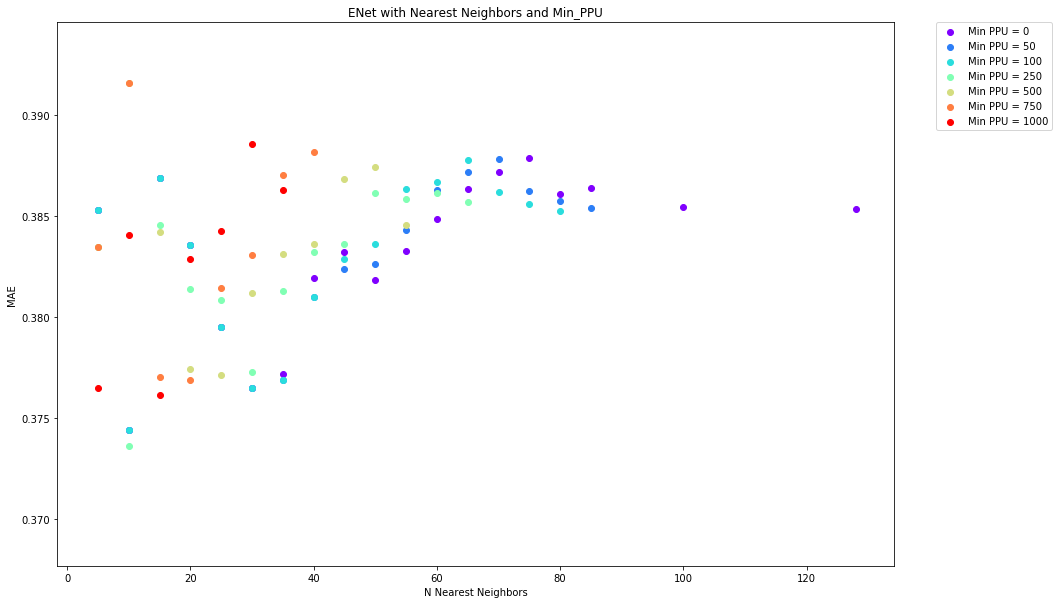

In [55]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


### Less Data

In [56]:
user_of_interest = 'tsharp93'

In [57]:
try:
    df.drop('nearest_neighbor_rank', axis=1, inplace=True)
except:
    pass

In [58]:
df = COSINE_STEP(df, user_of_interest)

User of Reference for Cosine Sim = tsharp93


In [64]:
features = ['ABV', 'IBU', 'global_rating']
target = 'user_rating'

In [65]:
df.head()

,nearest_neighbor_rank,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
0,1.0,r4ymond,Bramadero IPA,IPA - American,Del Oeste Brewery,6.715309,44.1594,3.56,4.00
1,1.0,r4ymond,FOK 2.3 Victoria,Sour - Berliner Weisse,F.O.K. Brewing LLC,5.200000,6,3.35,4.00
2,1.0,r4ymond,Quilmes Cristal,Lager - American,Cervecería y Maltería Quilmes,4.900000,12,2.92,4.00
3,1.0,r4ymond,Golden Monkey,Belgian Tripel,Victory Brewing Company,9.500000,25,3.77,3.00
4,1.0,r4ymond,B.O.B - Blood Orange Blonde,Blonde Ale,Ocean Lab Brewing Co.,5.500000,8,3.86,3.75


In [66]:
%%time

min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]


mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]
        y_train = np.array(y_train).reshape(len(y_train), )

        X_test = df[df['username'] == user_of_interest][features]
        y_test = df[df['username'] == user_of_interest][target]
        y_test = np.array(y_test).reshape(len(y_test), )

        # train
        from sklearn.linear_model import LassoCV
        model = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
#         preds_unscaled = y_scaler.inverse_transform(preds)
#         y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds, y_test]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5))
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.37082 with % within 0.25 40.0 and % within 0.5 67.5 for n = 5 with alpha = 3e-05
MAE = 0.35973 with % within 0.25 35.0 and % within 0.5 77.5 for n = 10 with alpha = 0.0
MAE = 0.36172 with % within 0.25 37.5 and % within 0.5 72.5 for n = 15 with alpha = 3e-05
MAE = 0.36863 with % within 0.25 32.5 and % within 0.5 72.5 for n = 20 with alpha = 0.0
MAE = 0.36928 with % within 0.25 37.5 and % within 0.5 70.0 for n = 25 with alpha = 0.0
MAE = 0.36833 with % within 0.25 35.0 and % within 0.5 72.5 for n = 30 with alpha = 0.0
MAE = 0.36788 with % within 0.25 35.0 and % within 0.5 72.5 for n = 35 with alpha = 0.0
MAE = 0.36614 with % within 0.25 37.5 and % within 0.5 72.5 for n = 40 with alpha = 0.0
MAE = 0.36566 with % within 0.25 37.5 and % within 0.5 70.0 for n = 45 with alpha = 0.0
MAE = 0.36411 with % within 0.25 35.0 and % within 0.5 70.0 for n = 50 with alpha = 0.0
MAE = 0.36352 with % within 0.25 35.0 and % within 0.5 70.0 for n = 55 with alpha = 0.0
MAE = 0.36339 with % within

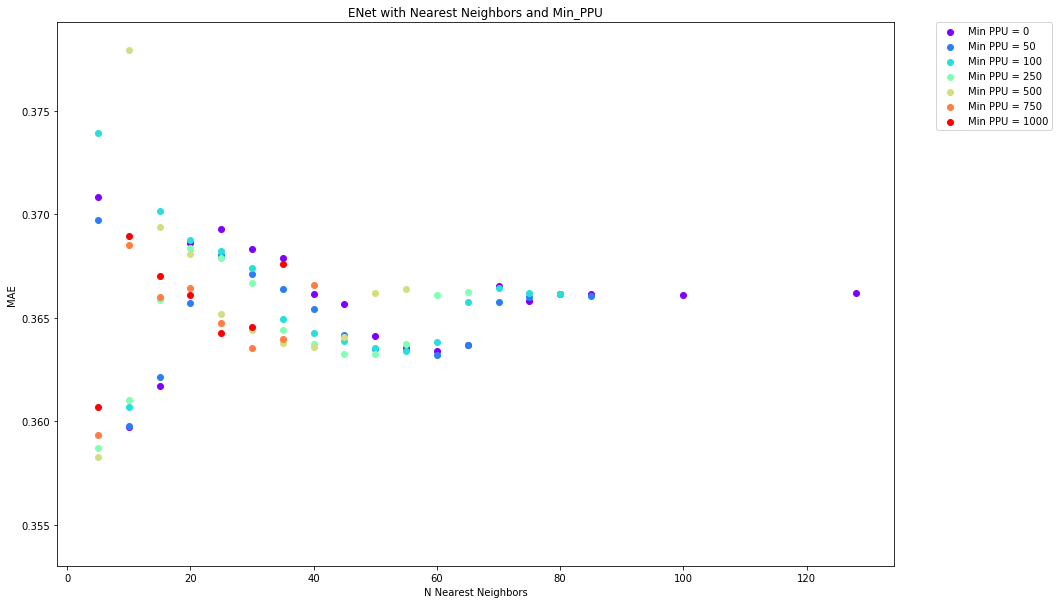

In [67]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
